In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import math
import random
import pickle
from scipy.stats import sem
from mpl_toolkits.axes_grid1 import make_axes_locatable

SLOPE = -3.379675
INTERCEPT = 50.84176
B = 1.93

In [2]:
data = pd.read_csv('israel.csv')
data['log10Load'] = (data['sample_viral_ct']-INTERCEPT)/SLOPE
data['log10Load'] = data['log10Load'].fillna(value=0)
data_pos = data.loc[data['log10Load'] > 0]
data_pos

,sample_id,pool_id,result,sample_viral_ct,sample_human_ct,pool_human_ct,pool_viral_ct,month,log10Load
2662,28467,4830,pos,19.12,19.49,23.200,23.354,4,9.386039
2692,125617,4851,pos,30.98,18.56,25.588,33.696,4,5.876825
8184,3062,15464,pos,26.00,23.00,24.339,27.214,4,7.350340
10100,116101,329,pos,18.96,20.78,25.817,25.328,5,9.433380
10612,20751,901,pos,23.74,27.02,30.040,29.256,5,8.019043
...,...,...,...,...,...,...,...,...,...
133615,57679,17710,pos,19.79,22.07,24.485,22.500,9,9.187795
133616,55204,17710,pos,15.45,22.07,24.485,22.500,9,10.471942
133617,71106,17710,pos,27.00,21.82,24.485,22.500,9,7.054453
133658,64883,17790,pos,31.86,25.10,27.603,37.504,9,5.616445


## Basic Testing Infrastructure

In [3]:
def run_test(load):
    return INTERCEPT + SLOPE*load

def flip(p):
    return 'N' if random.random() < p else 'P'

def semi_quant(load,th1=24,th2=39,truth=0):
    ct = run_test(load)
    if truth==0:
        if ct<th1:
            out= 2
        elif th1<ct<th2:
            out= 1
        else:
            out= 0
    else:
        fnr = FNR(th2,B,ct)
        fnr1 = FNR(th1,B,ct)
        flip2 = flip(fnr)
        flip1 = flip(fnr1)
        if flip1=='P':
            out=2
        elif flip2=='P':
            out=1
        else:
            out=0
        
    return out

def basic(load,thg=39,truth=0):
    ct = run_test(load)
    #print(ct)
    if truth==0:
        if ct<thg:
            out = 1
        else:
            out = 0
    else:
        fnr = FNR(thg,B,ct)
        flipr = flip(fnr)
        if flipr =='P':
            out=1
        else:
            out=0
    return out
        
    
def indiv_test(load,th):
    ct = run_test(load)
    if ct<th:
        return 1
    else:
        return 0
    
def run_baseline(table, th):
    levels = []
    cts = []
    for index, individual in table.iterrows():
        if individual['toTest']:
            cts.append(run_test(individual['log10Load']))
            levels.append(indiv_test(individual['log10Load'],th))
    table['Truth'] = levels
    table['TrueCT'] = cts
    return table

def FNR(a,b,x):
    return 1/(1+np.exp((a-x)/b))

In [4]:
sum([basic(4,35,1) for i in range(1000)])/1000

0.217

In [5]:
1-FNR(35,B,37.32306)

0.2308251124106787

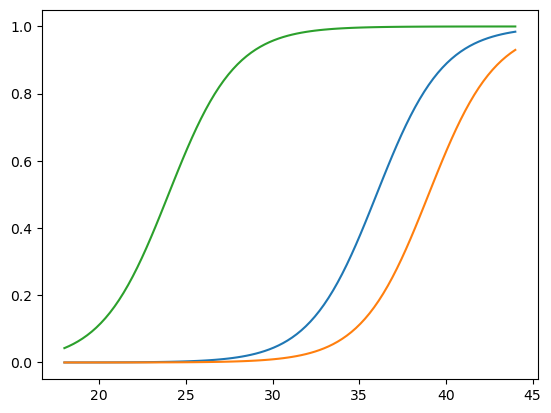

In [6]:
x = np.linspace(18, 44, 100)
plt.plot(x, FNR(36,1.93,x))
plt.plot(x, FNR(39,1.93,x))
plt.plot(x, FNR(24,1.93,x))

In [7]:
def group_test(table,g,th1,th2,coln):
    
    test_count = 0
    table = table.sample(frac=1).reset_index(drop=True) #shuffle data
    index = 0
    levs = []
    groups = []
    #print(math.floor(len(table)/g))
    for i in range(math.ceil(len(table)/g)):
        group = table[index:min(index+g,len(table))]
        #print(i,index,len(group))
        
        group_load = 0
        group_truth = 0
        for j, individual in group.iterrows():
            group_load += pow(10,individual['log10Load'])
            group_truth = group_truth or individual['Truth']
        group_load = np.log10(group_load/len(group))
        
        test_count+=1
        group_res = semi_quant(group_load,th1,th2,group_truth)
        levs+= [group_res]*len(group)
        groups+= [i]*len(group)
        
        index+=len(group)
        
    table[coln] = levs
    table[coln+'_group'] = groups
    
    return table,test_count

def basic_group_test(table,g,thg,coln):
    test_count = 0
    table = table.sample(frac=1).reset_index(drop=True) #shuffle data
    index = 0
    levs = []
    groups = []
    #print(math.floor(len(table)/g))
    for i in range(math.ceil(len(table)/g)):
        group = table[index:min(index+g,len(table))]
        #print(i,index,len(group))
        
        group_load = 0
        group_truth = 0
        for j, individual in group.iterrows():
            group_load += pow(10,individual['log10Load'])
            group_truth = group_truth or individual['Truth']
        group_load = np.log10(group_load/len(group))
        
        test_count+=1
        group_res = basic(group_load,thg,group_truth)
        levs+= [group_res]*len(group)
        groups+= [i]*len(group)
        
        index+=len(group)
        
    table[coln] = levs
    table[coln+'_group'] = groups
    
    return table,test_count
        
    

## Two Step Group Testing Function

In [8]:
def has_infected(inId,group):
    infected = {(1,1),(2,1),(1,2),(2,2)}
    has_infected = 0
    for index, individual in group.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if (scores in infected) and individual['IDs']!=inId:
            has_infected = 1
            #print(individual['IDs'],inId, scores)
    return has_infected

def two_step_cons(table,g,th1,th2,thi):
    count = 0
    
    table,t1_count = group_test(table,g,th1,th2,'Test1')
    table,t2_count = group_test(table,g,th1,th2,'Test2')
    count = count + t1_count+ t2_count
    
    clean = {(1,0),(0,1),(0,0)}
    infected = {(1,1),(2,1),(1,2),(2,2),(2,0),(0,2)}
    
    #print(table.columns)
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if scores in clean:
            final.append(0)
            indiv_tested.append(False)
        elif scores in infected:
            #final.append(1)
            count+=1
            final.append(basic(individual['log10Load'],thi,individual['Truth']))
            indiv_tested.append(True)
        else:
            if scores[0]==2:
                group_to_test = 'Test1_group'
            else:
                group_to_test = 'Test2_group'
            
            t1g = has_infected(individual['IDs'],table.loc[table[group_to_test] == individual[group_to_test]])
            if t1g:
            #if False:
                final.append(0)
                indiv_tested.append(False)
            else:
                count+=1
                final.append(basic(individual['log10Load'],thi,individual['Truth']))
                indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            
def two_step_lax(table,g,th1,th2,thi):
    count = 0
    
    table,t1_count = group_test(table,g,th1,th2,'Test1')
    table,t2_count = group_test(table,g,th1,th2,'Test2')
    count = count + t1_count+ t2_count
    
    clean = {(1,0),(0,1),(0,0),(2,0),(0,2)}
    infected = {(1,1),(2,1),(1,2),(2,2)}
    
    #print(table.columns)
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if scores in clean:
            final.append(0)
            indiv_tested.append(False)
        elif scores in infected:
            #final.append(1)
            count+=1
            final.append(basic(individual['log10Load'],thi,individual['Truth']))
            indiv_tested.append(True)
        else:
            if scores[0]==2:
                group_to_test = 'Test1_group'
            else:
                group_to_test = 'Test2_group'
            
            t1g = has_infected(individual['IDs'],table.loc[table[group_to_test] == individual[group_to_test]])
            if t1g:
            #if False:
                final.append(0)
                indiv_tested.append(False)
            else:
                count+=1
                final.append(basic(individual['log10Load'],thi,individual['Truth']))
                indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            
    
def two_step(table,g,th1,th2,thi):
    count = 0
    
    table,t1_count = group_test(table,g,th1,th2,'Test1')
    table,t2_count = group_test(table,g,th1,th2,'Test2')
    count = count + t1_count+ t2_count
    
    clean = {(1,0),(0,1),(0,0)}
    infected = {(1,1),(2,1),(1,2),(2,2)}
    
    #print(table.columns)
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        scores = (individual['Test1'],individual['Test2'])
        if scores in clean:
            final.append(0)
            indiv_tested.append(False)
        elif scores in infected:
            #final.append(1)
            count+=1
            final.append(basic(individual['log10Load'],thi,individual['Truth']))
            indiv_tested.append(True)
        else:
            if scores[0]==2:
                group_to_test = 'Test1_group'
            else:
                group_to_test = 'Test2_group'
            
            t1g = has_infected(individual['IDs'],table.loc[table[group_to_test] == individual[group_to_test]])
            if t1g:
            #if False:
                final.append(0)
                indiv_tested.append(False)
            else:
                count+=1
                final.append(basic(individual['log10Load'],thi,individual['Truth']))
                indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            

## Dorfman Function

In [9]:
def dorfman(table,g,thg,thi):
    count = 0
    
    table,tg_count = basic_group_test(table,g,thg,'Test1')
    count = count + tg_count
    
    final=[]
    indiv_tested = []
    for index, individual in table.iterrows():
        score = individual['Test1']
        if score==0:
            final.append(0)
            indiv_tested.append(False)
        else:
            count+=1
            final.append(basic(individual['log10Load'],thi,individual['Truth']))
            indiv_tested.append(True)
    
    table['Final'] = final
    table['TestedIndiv'] = indiv_tested
    return table, count            
    

In [10]:
def individual_scheme(table,thi):
    count = 0
    levels = []
    for index, individual in table.iterrows():
        if individual['toTest']:
            levels.append(basic(individual['log10Load'],thi,individual['Truth']))
            count+=1
    table['Final'] = levels
    return table,count

In [11]:
p = 0.1
gs = [2,3,5,8,12,15,20,25]
lax_count_lsg = []
lax_fnr_lsg = []
lax_fnr_sds = []
lax_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step_lax(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    lax_count_lsg.append(np.mean(count_r))
    lax_fnr_lsg.append(np.mean(fnr_r))
    lax_fnr_sds.append(np.std(fnr_r))
    lax_count_sds.append(np.std(count_r))

In [12]:
p = 0.1
gs = [2,3,5,8,12,15,20,25]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [13]:
p = 0.1
gs = [2,3,5,8,12,15,20,25]
indiv_count_lsg = []
indiv_fnr_lsg = []
indiv_fnr_sds = []
indiv_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        test1,count = individual_scheme(data_table,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    indiv_count_lsg.append(np.mean(count_r))
    indiv_fnr_lsg.append(np.mean(fnr_r))
    indiv_fnr_sds.append(np.std(fnr_r))
    indiv_count_sds.append(np.std(count_r))

In [14]:
p = 0.1
gs = [2,3,5,8,12,15,20,25]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

In [15]:
res_dict = {'sqgt':{'c':count_lsg,'cs':count_sds,'fnr':fnr_lsg,'fnrs':fnr_sds},
           'sqgt_lax':{'c':lax_count_lsg,'cs':lax_count_sds,'fnr':lax_fnr_lsg,'fnrs':lax_fnr_sds},
           'dorf':{'c':dorf_count_lsg,'cs':dorf_count_sds,'fnr':dorf_fnr_lsg,'fnrs':dorf_fnr_sds},
           'indiv':{'c':indiv_count_lsg,'cs':indiv_count_sds,'fnr':indiv_fnr_lsg,'fnrs':indiv_fnr_sds}}

In [16]:
# open a file, where you ant to store the data
file = open('01.pkl', 'wb')

# dump information to that file
pickle.dump(res_dict, file)

file.close()

In [17]:
with open("01.pkl", "rb") as input_file:
    e = pickle.load(input_file)

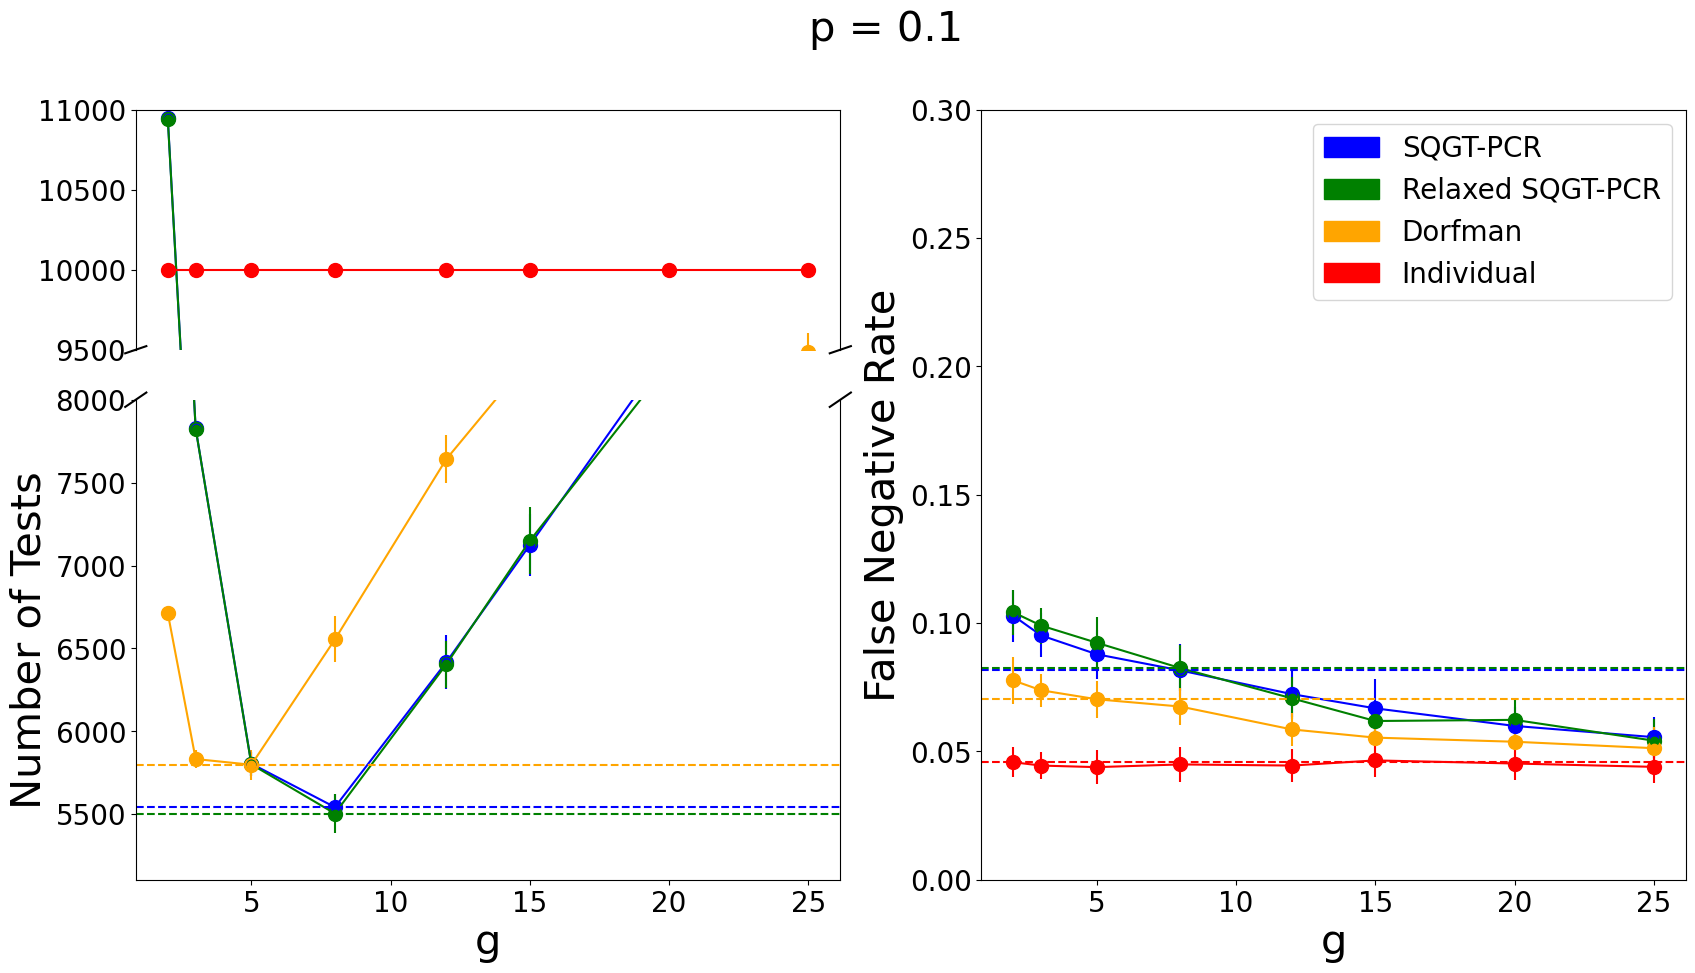

In [18]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

divider = make_axes_locatable(ax1)
ax12 = divider.new_vertical(size="50%", pad=0.5)
fig.add_axes(ax12)

"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax1.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax12.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax12.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax12.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax12.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax12.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax12.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax12.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax12.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax1.set_ylim(top=8000)
ax1.tick_params(top=False, labeltop=False)
ax1.spines['top'].set_visible(False)
ax12.set_ylim(9500, 11000)
ax12.tick_params(bottom=False, labelbottom=False)
ax12.spines['bottom'].set_visible(False)


ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,lax_fnr_lsg,marker='.',c='green',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.plot(gs,indiv_fnr_lsg,marker='.',c='red',markersize=20)

ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, lax_fnr_lsg,
             yerr = np.array(lax_fnr_sds),
             fmt ='o',c='green')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')
ax2.errorbar(gs, indiv_fnr_lsg,
             yerr = np.array(indiv_fnr_sds),
             fmt ='o',c='red')



legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT-PCR'),
                   Patch(facecolor='green', edgecolor='green',
                         label='Relaxed SQGT-PCR'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman'),
                  Patch(facecolor='red', edgecolor='red',
                         label='Individual')]
ax2.legend(handles=legend_elements, prop={'size': 20})

ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(lax_count_lsg),c='green',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax1.axhline(y=min(indiv_count_lsg),c='red',linestyle='--')

ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='--')
ax2.axhline(y=lax_fnr_lsg[lax_count_lsg.index(min(lax_count_lsg))],c='green',linestyle='--')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='--')
ax2.axhline(y=indiv_fnr_lsg[indiv_count_lsg.index(min(indiv_count_lsg))],c='red',linestyle='--')

ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax12.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim([0, 0.3])
#ax1.set_ylim(top=8000)

# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax12.transAxes, color='k', clip_on=False)
ax12.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax12.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.suptitle("p = 0.1", fontsize=30)
plt.savefig('1_final_sys_lax.pdf', format="pdf")

In [19]:
p = 0.02
gs = [2,3,5,8,12,15,20,25]
lax_count_lsg = []
lax_fnr_lsg = []
lax_fnr_sds = []
lax_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step_lax(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    lax_count_lsg.append(np.mean(count_r))
    lax_fnr_lsg.append(np.mean(fnr_r))
    lax_fnr_sds.append(np.std(fnr_r))
    lax_count_sds.append(np.std(count_r))

In [20]:
p = 0.02
gs = [2,3,5,8,12,15,20,25]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [21]:
p = 0.02
gs = [2,3,5,8,12,15,20,25]
indiv_count_lsg = []
indiv_fnr_lsg = []
indiv_fnr_sds = []
indiv_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        test1,count = individual_scheme(data_table,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    indiv_count_lsg.append(np.mean(count_r))
    indiv_fnr_lsg.append(np.mean(fnr_r))
    indiv_fnr_sds.append(np.std(fnr_r))
    indiv_count_sds.append(np.std(count_r))

In [22]:
p = 0.02
gs = [2,3,5,8,12,15,20,25]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

In [23]:
res_dict = {'sqgt':{'c':count_lsg,'cs':count_sds,'fnr':fnr_lsg,'fnrs':fnr_sds},
           'sqgt_lax':{'c':lax_count_lsg,'cs':lax_count_sds,'fnr':lax_fnr_lsg,'fnrs':lax_fnr_sds},
           'dorf':{'c':dorf_count_lsg,'cs':dorf_count_sds,'fnr':dorf_fnr_lsg,'fnrs':dorf_fnr_sds},
           'indiv':{'c':indiv_count_lsg,'cs':indiv_count_sds,'fnr':indiv_fnr_lsg,'fnrs':indiv_fnr_sds}}

In [24]:
# open a file, where you ant to store the data
file = open('002.pkl', 'wb')

# dump information to that file
pickle.dump(res_dict, file)

file.close()

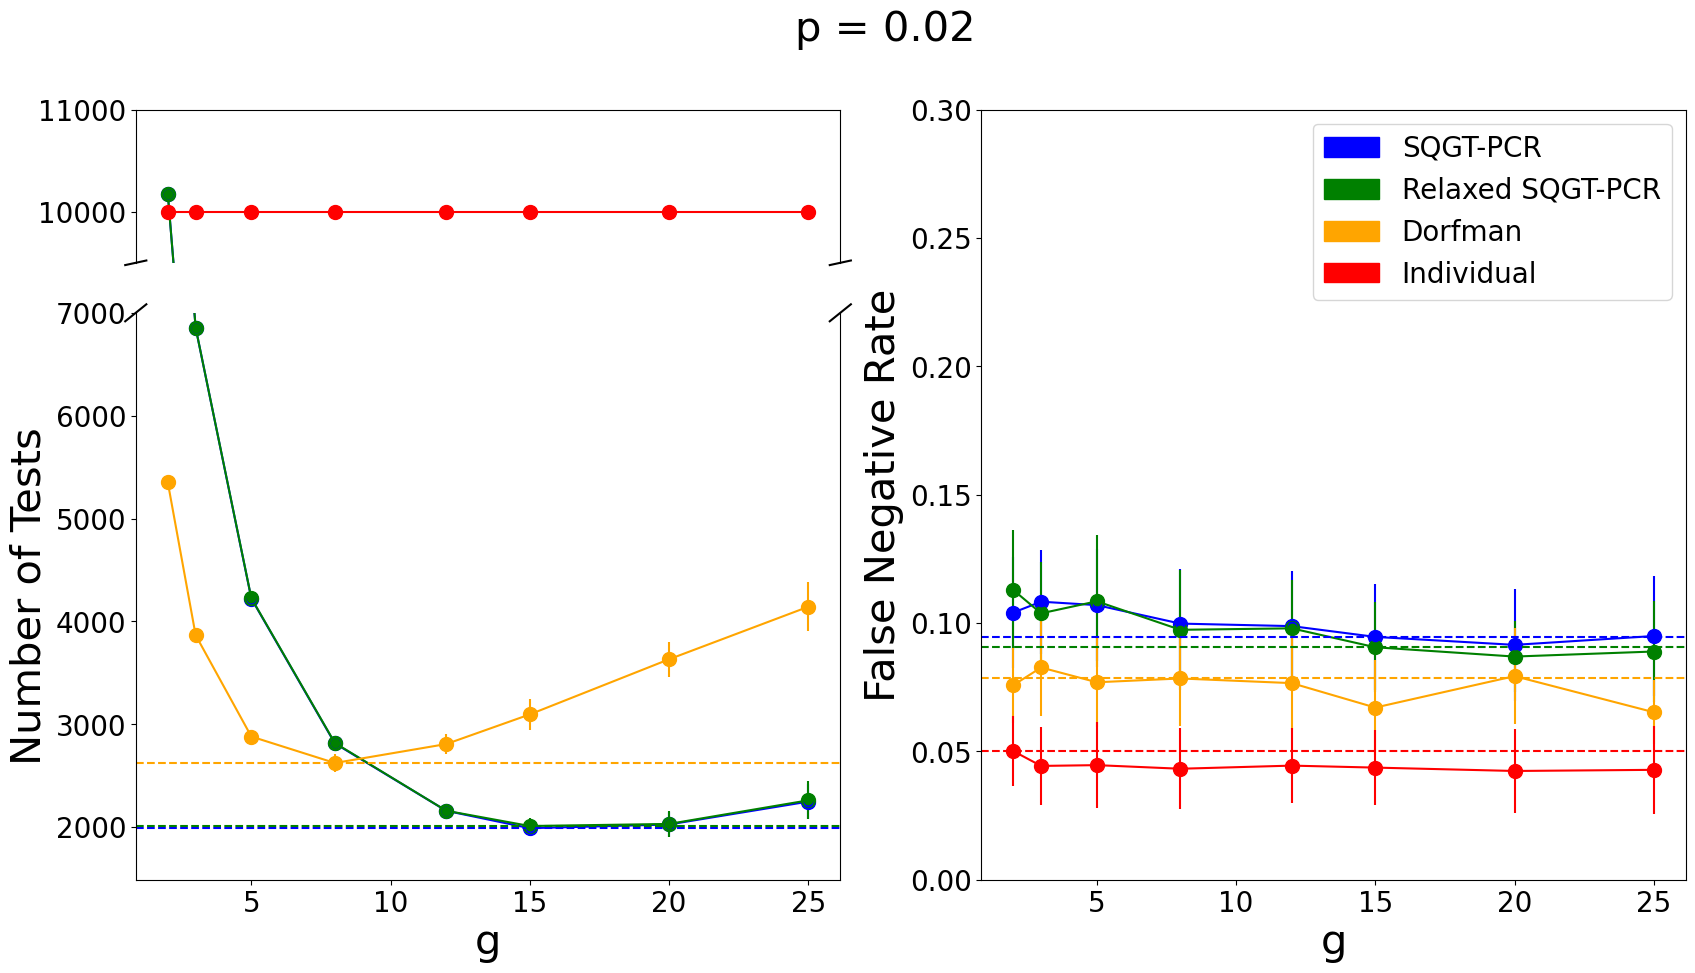

In [25]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

divider = make_axes_locatable(ax1)
ax12 = divider.new_vertical(size="27%", pad=0.5)
fig.add_axes(ax12)

"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax1.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax12.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax12.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax12.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax12.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax12.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax12.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax12.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax12.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax1.set_ylim(top=7000)
ax1.tick_params(top=False, labeltop=False)
ax1.spines['top'].set_visible(False)
ax12.set_ylim(9500, 11000)
ax12.tick_params(bottom=False, labelbottom=False)
ax12.spines['bottom'].set_visible(False)


ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,lax_fnr_lsg,marker='.',c='green',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.plot(gs,indiv_fnr_lsg,marker='.',c='red',markersize=20)

ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, lax_fnr_lsg,
             yerr = np.array(lax_fnr_sds),
             fmt ='o',c='green')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')
ax2.errorbar(gs, indiv_fnr_lsg,
             yerr = np.array(indiv_fnr_sds),
             fmt ='o',c='red')



legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT-PCR'),
                   Patch(facecolor='green', edgecolor='green',
                         label='Relaxed SQGT-PCR'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman'),
                  Patch(facecolor='red', edgecolor='red',
                         label='Individual')]
ax2.legend(handles=legend_elements, prop={'size': 20})

ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(lax_count_lsg),c='green',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax1.axhline(y=min(indiv_count_lsg),c='red',linestyle='--')

ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='--')
ax2.axhline(y=lax_fnr_lsg[lax_count_lsg.index(min(lax_count_lsg))],c='green',linestyle='--')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='--')
ax2.axhline(y=indiv_fnr_lsg[indiv_count_lsg.index(min(indiv_count_lsg))],c='red',linestyle='--')

ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax12.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim([0, 0.3])
#ax1.set_ylim(top=8000)

# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax12.transAxes, color='k', clip_on=False)
ax12.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax12.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.suptitle("p = 0.02", fontsize=30)
plt.savefig('02_final_sys_lax.pdf', format="pdf")

In [26]:
p = 0.05
gs = [2,3,5,8,12,15,20,25]
lax_count_lsg = []
lax_fnr_lsg = []
lax_fnr_sds = []
lax_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step_lax(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    lax_count_lsg.append(np.mean(count_r))
    lax_fnr_lsg.append(np.mean(fnr_r))
    lax_fnr_sds.append(np.std(fnr_r))
    lax_count_sds.append(np.std(count_r))

In [27]:
p = 0.05
gs = [2,3,5,8,12,15,20,25]
count_lsg = []
fnr_lsg = []
fnr_sds = []
count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
        #th2 = 36+math.ceil(np.log2(g))
        #th1 = 36 - 15 + math.ceil(np.log2(g))
        test1,count = two_step(data_table,g,th1,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    count_lsg.append(np.mean(count_r))
    fnr_lsg.append(np.mean(fnr_r))
    fnr_sds.append(np.std(fnr_r))
    count_sds.append(np.std(count_r))

In [28]:
p = 0.05
gs = [2,3,5,8,12,15,20,25]
indiv_count_lsg = []
indiv_fnr_lsg = []
indiv_fnr_sds = []
indiv_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        test1,count = individual_scheme(data_table,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    indiv_count_lsg.append(np.mean(count_r))
    indiv_fnr_lsg.append(np.mean(fnr_r))
    indiv_fnr_sds.append(np.std(fnr_r))
    indiv_count_sds.append(np.std(count_r))

In [29]:
p = 0.05
gs = [2,3,5,8,12,15,20,25]
dorf_count_lsg = []
dorf_fnr_lsg = []
dorf_fnr_sds = []
dorf_count_sds = []
for g in gs:
    count_r = []
    fnr_r =[]
    for r in range(30):
        loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
        data_table = pd.DataFrame(loads,columns=['log10Load'])
        data_table['IDs'] = [i for i in range(len(data_table))]
        data_table['toTest'] = [True for i in range(len(data_table))]
        data_table = data_table.sample(frac=1).reset_index(drop=True)
        data_table = data_table[:10000]
        data_table = run_baseline(data_table,36)
        #th2 = 36+math.ceil(np.log2(g))
        th2 = 36+(np.log10(g)*np.abs(SLOPE))
        test1,count = dorfman(data_table,g,th2,36)
        cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
        tn, fp, fn, tp = cnf_matrix.ravel()
        count_r.append(count)
        fnr_r.append(fn/(tp+fn))
    dorf_count_lsg.append(np.mean(count_r))
    dorf_fnr_lsg.append(np.mean(fnr_r))
    dorf_fnr_sds.append(np.std(fnr_r))
    dorf_count_sds.append(np.std(count_r))

In [30]:
res_dict = {'sqgt':{'c':count_lsg,'cs':count_sds,'fnr':fnr_lsg,'fnrs':fnr_sds},
           'sqgt_lax':{'c':lax_count_lsg,'cs':lax_count_sds,'fnr':lax_fnr_lsg,'fnrs':lax_fnr_sds},
           'dorf':{'c':dorf_count_lsg,'cs':dorf_count_sds,'fnr':dorf_fnr_lsg,'fnrs':dorf_fnr_sds},
           'indiv':{'c':indiv_count_lsg,'cs':indiv_count_sds,'fnr':indiv_fnr_lsg,'fnrs':indiv_fnr_sds}}

In [31]:
# open a file, where you ant to store the data
file = open('005.pkl', 'wb')

# dump information to that file
pickle.dump(res_dict, file)

file.close()

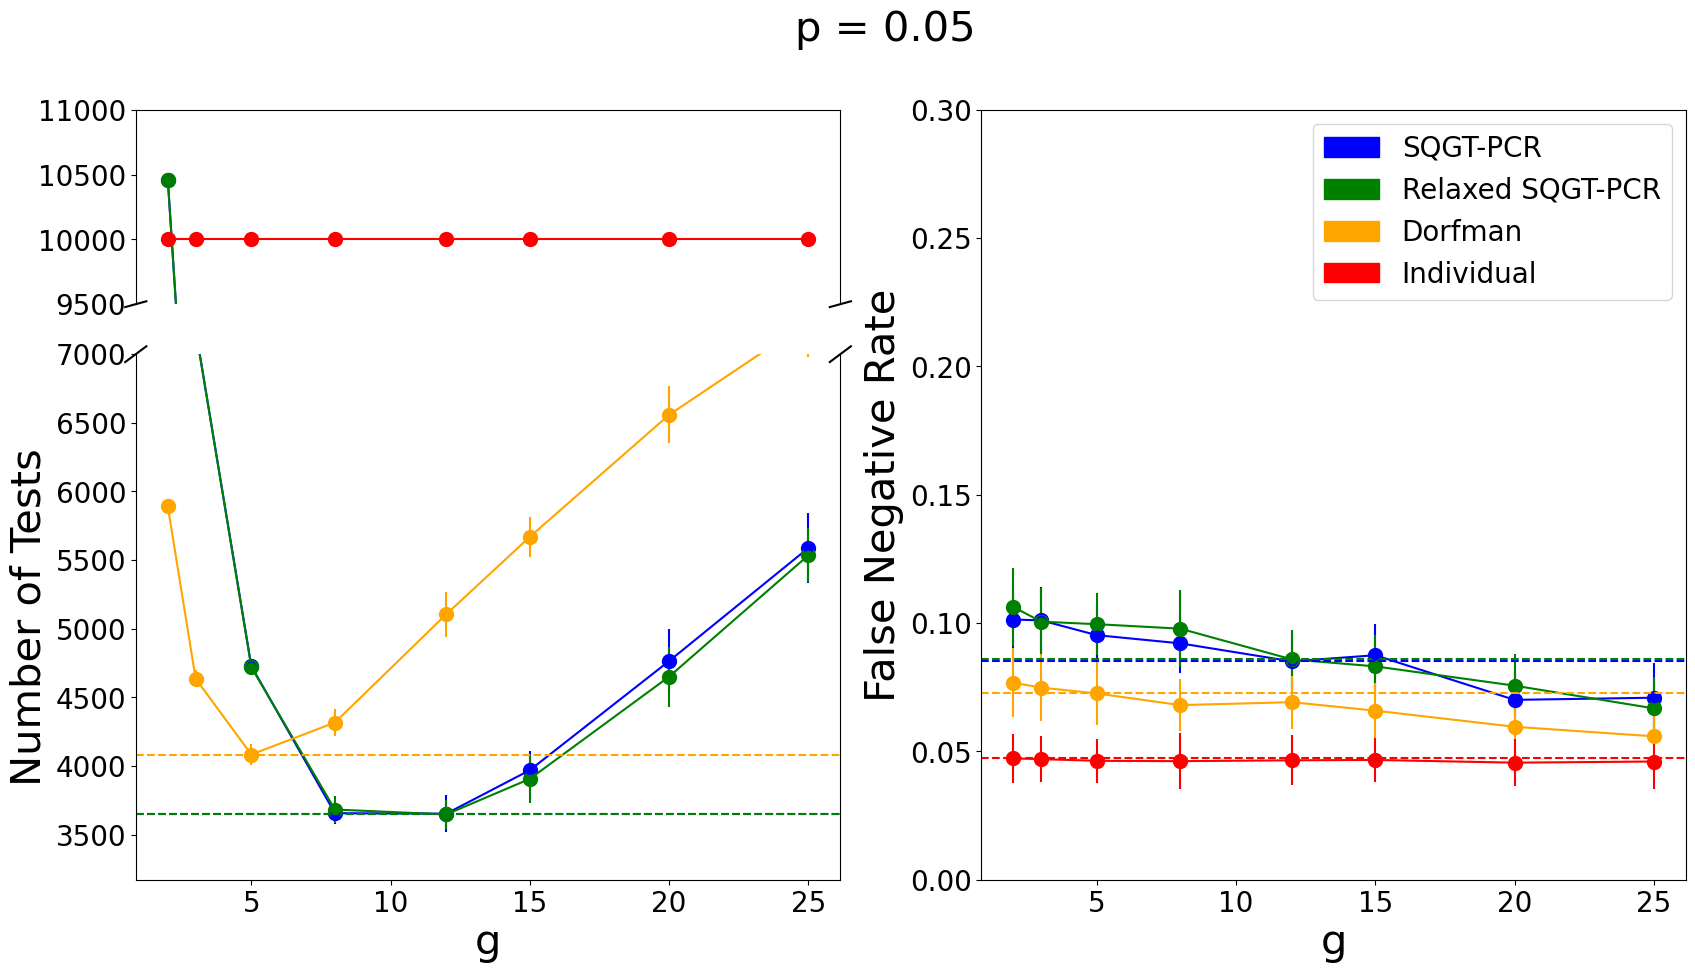

In [32]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

divider = make_axes_locatable(ax1)
ax12 = divider.new_vertical(size="37%", pad=0.5)
fig.add_axes(ax12)

"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax1.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax1.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax1.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax1.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax1.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax1.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax1.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax12.plot(gs,count_lsg,marker='.',c='blue',markersize=20)
ax12.plot(gs,lax_count_lsg,marker='.',c='green',markersize=20)
ax12.plot(gs,dorf_count_lsg,marker='.',c='orange',markersize=20)
ax12.plot(gs,indiv_count_lsg,marker='.',c='red',markersize=20)
ax12.errorbar(gs, count_lsg,
             yerr = np.array(count_sds),
             fmt ='o',c='blue')
ax12.errorbar(gs, lax_count_lsg,
             yerr = np.array(lax_count_sds),
             fmt ='o',c='green')
ax12.errorbar(gs, dorf_count_lsg,
             yerr = np.array(dorf_count_sds),
             fmt ='o',c='orange')
ax12.errorbar(gs, indiv_count_lsg,
             yerr = np.array(indiv_count_sds),
             fmt ='o',c='red')

ax1.set_ylim(top=7000)
ax1.tick_params(top=False, labeltop=False)
ax1.spines['top'].set_visible(False)
ax12.set_ylim(9500, 11000)
ax12.tick_params(bottom=False, labelbottom=False)
ax12.spines['bottom'].set_visible(False)


ax2.plot(gs,fnr_lsg,marker='.',c='blue',markersize=20)
ax2.plot(gs,lax_fnr_lsg,marker='.',c='green',markersize=20)
ax2.plot(gs,dorf_fnr_lsg,marker='.',c='orange',markersize=20)
ax2.plot(gs,indiv_fnr_lsg,marker='.',c='red',markersize=20)

ax2.errorbar(gs, fnr_lsg,
             yerr = np.array(fnr_sds),
             fmt ='o',c='blue')
ax2.errorbar(gs, lax_fnr_lsg,
             yerr = np.array(lax_fnr_sds),
             fmt ='o',c='green')
ax2.errorbar(gs, dorf_fnr_lsg,
             yerr = np.array(dorf_fnr_sds),
             fmt ='o',c='orange')
ax2.errorbar(gs, indiv_fnr_lsg,
             yerr = np.array(indiv_fnr_sds),
             fmt ='o',c='red')



legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT-PCR'),
                   Patch(facecolor='green', edgecolor='green',
                         label='Relaxed SQGT-PCR'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman'),
                  Patch(facecolor='red', edgecolor='red',
                         label='Individual')]
ax2.legend(handles=legend_elements, prop={'size': 20})

ax1.axhline(y=min(count_lsg),c='blue',linestyle='--')
ax1.axhline(y=min(lax_count_lsg),c='green',linestyle='--')
ax1.axhline(y=min(dorf_count_lsg),c='orange',linestyle='--')
ax1.axhline(y=min(indiv_count_lsg),c='red',linestyle='--')

ax2.axhline(y=fnr_lsg[count_lsg.index(min(count_lsg))],c='blue',linestyle='--')
ax2.axhline(y=lax_fnr_lsg[lax_count_lsg.index(min(lax_count_lsg))],c='green',linestyle='--')
ax2.axhline(y=dorf_fnr_lsg[dorf_count_lsg.index(min(dorf_count_lsg))],c='orange',linestyle='--')
ax2.axhline(y=indiv_fnr_lsg[indiv_count_lsg.index(min(indiv_count_lsg))],c='red',linestyle='--')

ax1.set_ylabel('Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('g',fontsize=30)
ax2.set_xlabel('g',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax12.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim([0, 0.3])
#ax1.set_ylim(top=8000)

# From https://matplotlib.org/examples/pylab_examples/broken_axis.html
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax12.transAxes, color='k', clip_on=False)
ax12.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax12.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.suptitle("p = 0.05", fontsize=30)
plt.savefig('05_final_sys_lax.pdf', format="pdf")

In [55]:
ps = [0.01,0.03,0.05,0.07,0.09,0.1]
count_sweep = []
fnr_sweep = []
count_sweep_sd = []
fnr_sweep_sd = []
for p in ps:
    gs = [2,3,5,8,12,15,20,25]
    count_lsg = []
    fnr_lsg = []
    fnr_sds = []
    count_sds = []
    for g in gs:
        count_r = []
        fnr_r =[]
        for r in range(30):
            loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
            data_table = pd.DataFrame(loads,columns=['log10Load'])
            data_table['IDs'] = [i for i in range(len(data_table))]
            data_table['toTest'] = [True for i in range(len(data_table))]
            data_table = data_table.sample(frac=1).reset_index(drop=True)
            data_table = data_table[:10000]
            data_table = run_baseline(data_table,36)
            th2 = 36+(np.log10(g)*np.abs(SLOPE))
            th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
            #th2 = 36+math.ceil(np.log2(g))
            #th1 = 36 - 15 + math.ceil(np.log2(g))
            test1,count = two_step(data_table,g,th1,th2,36)
            cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
            tn, fp, fn, tp = cnf_matrix.ravel()
            count_r.append(count)
            fnr_r.append(fn/(tp+fn))
        count_lsg.append(np.mean(count_r))
        fnr_lsg.append(np.mean(fnr_r))
        fnr_sds.append(np.std(fnr_r))
        count_sds.append(np.std(count_r))
        
    count_sweep.append(min(count_lsg))
    fnr_sweep.append(fnr_lsg[count_lsg.index(min(count_lsg))])
    fnr_sweep_sd.append(fnr_sds[count_lsg.index(min(count_lsg))])
    count_sweep_sd.append(count_sds[count_lsg.index(min(count_lsg))])

In [56]:
ps = [0.01,0.03,0.05,0.07,0.09,0.1]
dorf_count_sweep = []
dorf_fnr_sweep = []
dorf_count_sweep_sd = []
dorf_fnr_sweep_sd = []
for p in ps:
    gs = [2,3,5,8,12,15,20,25]
    count_lsg = []
    fnr_lsg = []
    fnr_sds = []
    count_sds = []
    for g in gs:
        count_r = []
        fnr_r =[]
        for r in range(30):
            loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
            data_table = pd.DataFrame(loads,columns=['log10Load'])
            data_table['IDs'] = [i for i in range(len(data_table))]
            data_table['toTest'] = [True for i in range(len(data_table))]
            data_table = data_table.sample(frac=1).reset_index(drop=True)
            data_table = data_table[:10000]
            data_table = run_baseline(data_table,36)
            th2 = 36+(np.log10(g)*np.abs(SLOPE))
            test1,count = dorfman(data_table,g,th2,36)
            cnf_matrix = confusion_matrix(test1['Truth'], test1['Final'])
            tn, fp, fn, tp = cnf_matrix.ravel()
            count_r.append(count)
            fnr_r.append(fn/(tp+fn))
        count_lsg.append(np.mean(count_r))
        fnr_lsg.append(np.mean(fnr_r))
        fnr_sds.append(np.std(fnr_r))
        count_sds.append(np.std(count_r))
        
    dorf_count_sweep.append(min(count_lsg))
    dorf_fnr_sweep.append(fnr_lsg[count_lsg.index(min(count_lsg))])
    dorf_fnr_sweep_sd.append(fnr_sds[count_lsg.index(min(count_lsg))])
    dorf_count_sweep_sd.append(count_sds[count_lsg.index(min(count_lsg))])

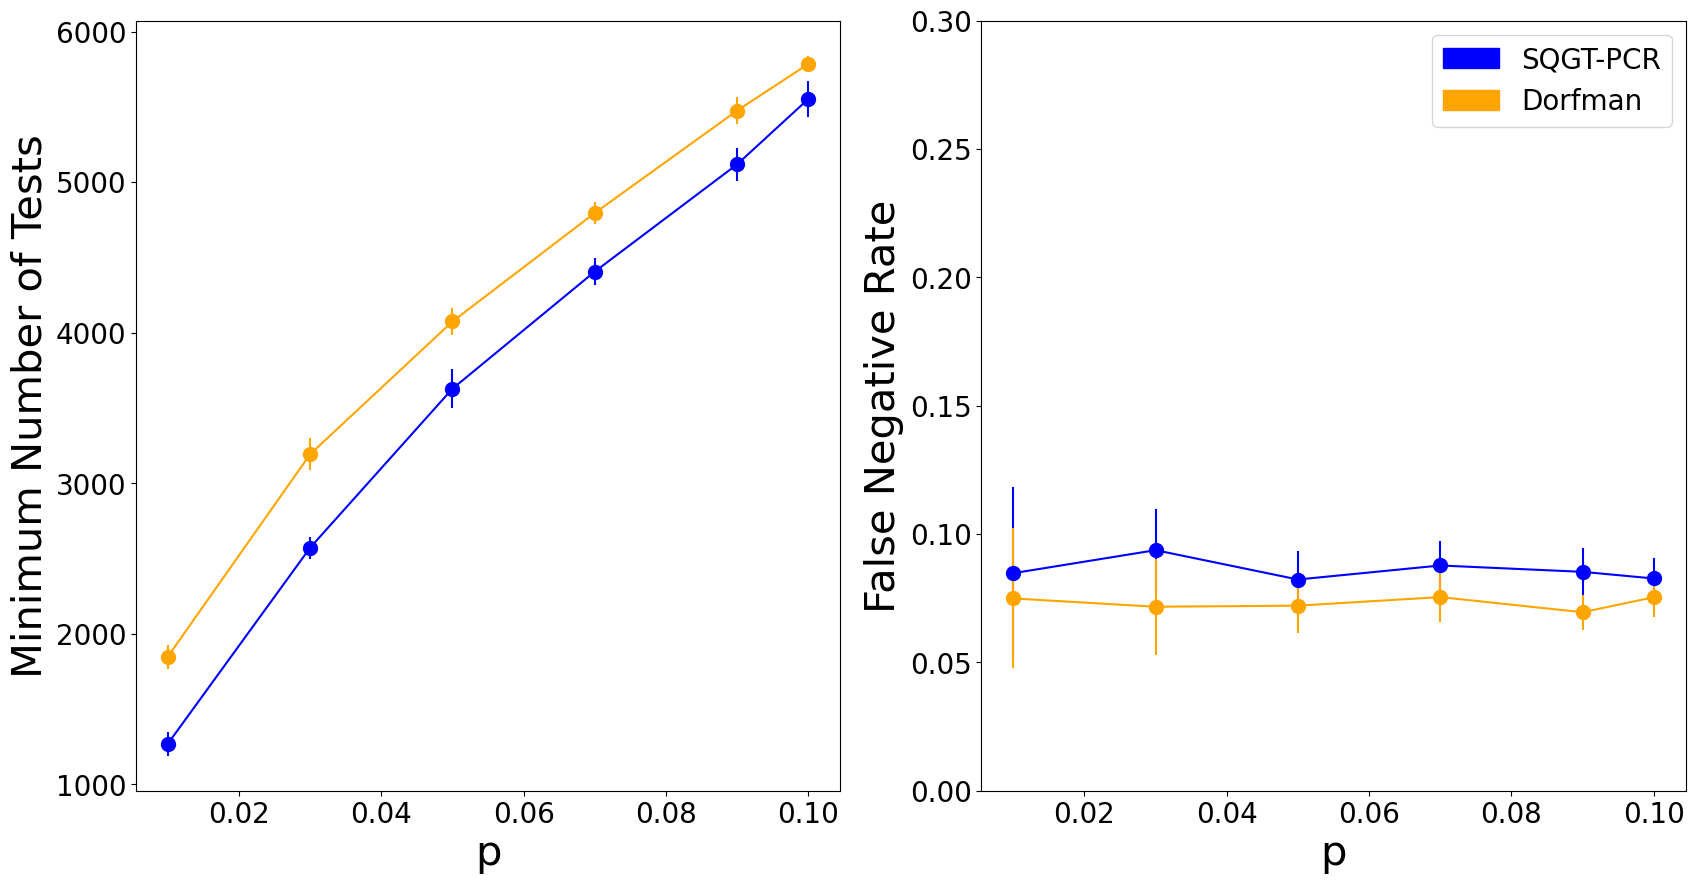

In [62]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
"""ax1.plot(ps,count_ls,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_ls,marker='.',c='orange',markersize=20)
ax2.plot(ps,fnr_ls,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_ls,marker='.',c='orange',markersize=20)
"""
ax1.plot(ps,count_sweep,marker='.',c='blue',markersize=20)
ax1.plot(ps,dorf_count_sweep,marker='.',c='orange',markersize=20)
ax1.errorbar(ps, count_sweep,
             yerr = np.array(count_sweep_sd),
             fmt ='o',c='blue')
ax1.errorbar(ps, dorf_count_sweep,
             yerr = np.array(dorf_count_sweep_sd),
             fmt ='o',c='orange')

ax2.plot(ps,fnr_sweep,marker='.',c='blue',markersize=20)
ax2.plot(ps,dorf_fnr_sweep,marker='.',c='orange',markersize=20)
ax2.errorbar(ps, fnr_sweep,
             yerr = np.array(fnr_sweep_sd),
             fmt ='o',c='blue')
ax2.errorbar(ps, dorf_fnr_sweep,
             yerr = np.array(dorf_fnr_sweep_sd),
             fmt ='o',c='orange')

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='SQGT-PCR'),
                  Patch(facecolor='orange', edgecolor='orange',
                         label='Dorfman')]
ax2.legend(handles=legend_elements, prop={'size': 20})


ax1.set_ylabel('Minimum Number of Tests',fontsize=30)
ax2.set_ylabel('False Negative Rate',fontsize=30)
ax1.set_xlabel('p',fontsize=30)
ax2.set_xlabel('p',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim([0, 0.3])
#ax1.set_ylim(top=8000)
#plt.suptitle("p = 0.1", fontsize=30)
plt.savefig('p_sweep.pdf', format="pdf")

In [60]:
res_dict = {'sqgt':{'c':count_sweep,'cs':count_sweep_sd,'fnr':fnr_sweep,'fnrs':fnr_sweep_sd},
           'dorf':{'c':dorf_count_sweep,'cs':dorf_count_sweep_sd,'fnr':dorf_fnr_sweep,'fnrs':dorf_fnr_sweep_sd}}

In [61]:
# open a file, where you ant to store the data
file = open('p_sweep.pkl', 'wb')

# dump information to that file
pickle.dump(res_dict, file)

file.close()

In [17]:
with open("01.pkl", "rb") as input_file:
    e = pickle.load(input_file)

In [19]:
min(e['sqgt']['c'])

5542.233333333334

In [21]:
e['dorf']['c']

[6712.333333333333,
 5832.533333333334,
 5798.0,
 6554.0,
 7641.333333333333,
 8249.5,
 9014.666666666666,
 9487.5]

In [22]:
(min(e['dorf']['c'])-min(e['sqgt']['c']))/min(e['dorf']['c'])

0.04411291249856268

In [23]:
e['sqgt']['fnr'][e['sqgt']['c'].index(min(e['sqgt']['c']))]

0.08154838101872854

In [24]:
e['dorf']['fnr'][e['dorf']['c'].index(min(e['dorf']['c']))]

0.07030270696229009

In [63]:
p = 0.05
g = 12
pos_break = []
neg_break =[]
for r in range(20):
    loads = list(data_pos['log10Load']) + [0 for i in range(math.ceil(len(data_pos)/p) - len(data_pos))]
    data_table = pd.DataFrame(loads,columns=['log10Load'])
    data_table['IDs'] = [i for i in range(len(data_table))]
    data_table['toTest'] = [True for i in range(len(data_table))]
    data_table = data_table.sample(frac=1).reset_index(drop=True)
    data_table = data_table[:10000]
    data_table = run_baseline(data_table,36)
    th2 = 36+(np.log10(g)*np.abs(SLOPE))
    th1 = 36 - 15 +(np.log10(g)*np.abs(SLOPE))
    #th2 = 36+math.ceil(np.log2(g))
    #th1 = 36 - 15 + math.ceil(np.log2(g))
    test1,count = two_step(data_table,g,th1,th2,36)
    pos_trus = test1.loc[test1['Truth']==1]
    pos_break.append([len(pos_trus.loc[(pos_trus['Test1']==0) & (pos_trus['Test2']==0)]), len(pos_trus.loc[(pos_trus['Test1']==0) & (pos_trus['Test2']==1)]), len(pos_trus.loc[(pos_trus['Test1']==1) & (pos_trus['Test2']==0)])
     ,len(pos_trus.loc[(pos_trus['Test1']==1) & (pos_trus['Test2']==1)]), len(pos_trus.loc[(pos_trus['Test1']==2) & (pos_trus['Test2']==0)]), len(pos_trus.loc[(pos_trus['Test1']==0) & (pos_trus['Test2']==2)])
     ,len(pos_trus.loc[(pos_trus['Test1']==2) & (pos_trus['Test2']==1)]), len(pos_trus.loc[(pos_trus['Test1']==1) & (pos_trus['Test2']==2)]), len(pos_trus.loc[(pos_trus['Test1']==2) & (pos_trus['Test2']==2)])])
    neg_trus = test1.loc[test1['Truth']==0]
    neg_break.append([len(neg_trus.loc[(neg_trus['Test1']==0) & (neg_trus['Test2']==0)]), len(neg_trus.loc[(neg_trus['Test1']==0) & (neg_trus['Test2']==1)]), len(neg_trus.loc[(neg_trus['Test1']==1) & (neg_trus['Test2']==0)])
     ,len(neg_trus.loc[(neg_trus['Test1']==1) & (neg_trus['Test2']==1)]), len(neg_trus.loc[(neg_trus['Test1']==2) & (neg_trus['Test2']==0)]), len(neg_trus.loc[(neg_trus['Test1']==0) & (neg_trus['Test2']==2)])
     ,len(neg_trus.loc[(neg_trus['Test1']==2) & (neg_trus['Test2']==1)]), len(neg_trus.loc[(neg_trus['Test1']==1) & (neg_trus['Test2']==2)]), len(neg_trus.loc[(neg_trus['Test1']==2) & (neg_trus['Test2']==2)])])


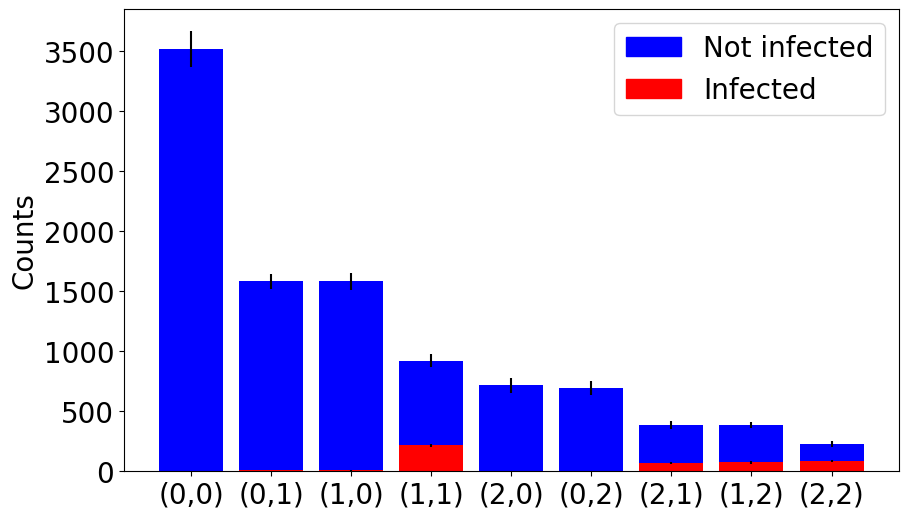

In [64]:
# create data
x = ['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(2,0)','(0,2)', '(2,1)','(1,2)','(2,2)']
y1 = np.mean(pos_break,axis=0)
y2 = np.mean(neg_break,axis=0)
 
# plot bars in stack manner
plt.figure(figsize=(10,6))
plt.bar(x, y1, color='r',yerr=np.std(pos_break,axis=0))
plt.bar(x, y2, bottom=y1, color='b',yerr=np.std(neg_break,axis=0))

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Not infected'),
                  Patch(facecolor='red', edgecolor='red',
                         label='Infected')]

plt.legend(handles=legend_elements, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.savefig('breakdown.pdf')
plt.show()